In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
import time
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

In [159]:
N = 10

sigma1 = np.array([[0,1],[1,0]])
sigma2 = np.array([[0,-1j],[1j,0]])
sigma3 = np.array([[1,0],[0,-1]])

def calculate_action(lattice,beta):
 
    # Calculate the plaquette term in the action
    i_shifted = np.roll(lattice, shift=-1, axis=0)
    j_shifted = np.roll(lattice, shift=-1, axis=1)

    plaq = np.matmul(lattice[..., 0, :, :], j_shifted[..., 1, :, :])
    plaq = np.matmul(plaq, np.conj(i_shifted[..., 0, :, :]).transpose(0, 1, 3, 2))
    plaq = np.matmul(plaq, np.conj(lattice[..., 1, :, :]).transpose(0, 1, 3, 2))

    action_plaquette = np.real(2 - np.trace(plaq, axis1=-2, axis2=-1)).sum()

    # Calculate the total action
    return 2 * beta * action_plaquette

'''
def wilson(lattice,a):
    p = np.eye(2,dtype=complex)
    q = np.eye(2,dtype=complex)
    r = np.eye(2,dtype=complex)
    s = np.eye(2,dtype=complex)
    for i in range(0,a):
        p = np.matmul(p,lattice[i,N-1,0])
    for j in range(0,a):
        q = np.matmul(q,lattice[a,N-1-j,1])
    for i in range(0,a):
        r = np.matmul(r,np.conj(lattice[a-i,N-a-1,0]))
    for j in range(0,a):
        s = np.matmul(s,np.conj(lattice[0,N-a-1+j,1]))
    return np.real(np.trace(p.dot(q.dot(r.dot(s)))))
'''

def plaquette(i,j,lattice):
    return lattice[i,j,0].dot(lattice[(i+1)%N,j,1].dot(np.conj(lattice[i,(j+1)%N,0].T).dot(np.conj(lattice[i,j,1].T))))

#plaquette = np.vectorize(plaquette)

def wilson(lattice, a):
    i, j = np.indices((a, a))
    plaquettes = plaquette(i, j, lattice)
    p = np.prod(plaquettes)
    return np.real(p)


def X(eps):
    r = np.random.uniform(low=-1/2,high=1/2,size=4)
    x0 =  np.sign(r[0]) * np.sqrt(1 - eps**2)
    x = eps * r[1:]/np.linalg.norm(r[1:])
    return x0 * np.eye(2) + 1j * (x[0] * sigma1 + x[1] * sigma2 + x[2] * sigma3)

def metropolis(beta,n_iterations=100000):
    
    # Initialize lattice with random SU(2) matrices
    lattice = np.zeros((N, N, 2, 2, 2), dtype=np.complex128)
    xvals = np.random.uniform(low=-10, high=10, size=(N, N, 2, 4))
    xvec = xvals / np.linalg.norm(xvals, axis=-1, keepdims=True)  # Normalize each vector

    arr = xvec[..., 0, None, None] * np.eye(2) + 1j * (xvec[..., 1, None, None] * sigma1 + xvec[..., 2, None, None] * sigma2 + xvec[..., 3, None, None] * sigma3)
    lattice[..., 0] = arr[..., 0]
    lattice[..., 1] = arr[..., 1]
   
    # Apply periodic boundary conditions
    lattice[0, :, :] = lattice[N-1, :, :]
    lattice[:,0, :] = lattice[:, N-1, :]            

    action_before = calculate_action(lattice,beta)
    ls = [[] for _ in range(N-1)]
        
    for iteration in range(n_iterations):
    
        # Choose a random lattice site and direction
        i = np.random.randint(N)
        j = np.random.randint(N)
        k = np.random.randint(2)

        # Generate a random SU(2) matrix
        su2_matrix = X(0.5)
        
        new_lattice = lattice.copy()

        # Update the gauge field at the chosen site
        new_lattice[i, j, k] = np.matmul(su2_matrix, new_lattice[i, j, k])
        
        # Apply periodic boundary conditions
        new_lattice[0, :, :] = new_lattice[N-1, :, :]
        new_lattice[:,0, :] = new_lattice[:, N-1, :]

        # Calculate the action after the update
        action_after = calculate_action(new_lattice,beta)

        # Decide whether to accept or reject the update
        if np.random.random() < np.exp(action_before - action_after):
            # Accept the update
            lattice = new_lattice
            action_before = action_after
            
        if iteration >= 9*n_iterations/10:
            for i in range(N-1):
                ls[i].append(wilson(lattice,i+1))
    
    for i in range(N-1):
        ls[i] = np.array(ls[i]).mean()
        
    return ls

In [160]:
num_cores = multiprocessing.cpu_count()
betas = np.linspace(0, 2, 5)

with Parallel(n_jobs=num_cores) as parallel:
    ls = parallel(delayed(metropolis)(beta) for beta in tqdm(betas))

    arr = np.array(ls)
    side = np.arange(1,N)
    for i in range(len(betas)):
        plt.plot(side,arr[i,:],label=f'{betas[i]}')
    plt.xlabel('Side of loop')
    plt.ylabel('Wilson loop')
    plt.legend()
    plt.show()

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 30660.12it/s]
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py

KeyboardInterrupt: 

In [101]:
# Define the action function
def calculate_action(lattice,beta):
 
    # Calculate the plaquette term in the action
    i_shifted = np.roll(lattice, shift=-1, axis=0)
    j_shifted = np.roll(lattice, shift=-1, axis=1)

    plaq = lattice[..., 0] * j_shifted[..., 1] * np.conj(i_shifted[..., 0]) * np.conj(lattice[..., 1])

    action_plaquette = np.real(1 - plaq).sum()

    # Calculate the total action
    return 2 * beta * action_plaquette

def wilson(lattice,a):
    p, q, r, s = 1, 1, 1, 1
    for i in range(0,a):
        p *= lattice[i,N-1,0]
    for j in range(0,a):
        q *= lattice[a,N-1-j,1]
    for i in range(0,a):
        r *= np.conj(lattice[a-i,N-a-1,0])
    for j in range(0,a):
        s *= np.conj(lattice[0,N-a-1+j,1])
    return np.real(p*q*r*s)

def X(eps):
    return np.exp(1j * np.random.uniform(low=0,high=2*np.pi))

def metropolis(beta,n_iterations=100000):
    
    # Initialize lattice with random U(1) elements
    lattice = np.exp(1j * np.random.uniform(low = 0, high = 2*np.pi, size=(N,N,2)))

    # Apply periodic boundary conditions
    lattice[0, :, :] = lattice[N-1, :, :]
    lattice[:,0, :] = lattice[:, N-1, :]            

    action_before = calculate_action(lattice,beta)
    ls = [[] for _ in range(N-1)]
        
    for iteration in range(n_iterations):
    
        # Choose a random lattice site and direction
        i = np.random.randint(N)
        j = np.random.randint(N)
        k = np.random.randint(2)

        # Generate a random U(1) element
        u1_elem = X(0.5)
        
        new_lattice = lattice.copy()

        # Update the gauge field at the chosen site
        new_lattice[i, j, k] = u1_elem * new_lattice[i, j, k]
        
        # Apply periodic boundary conditions
        new_lattice[0, :, :] = new_lattice[N-1, :, :]
        new_lattice[:,0, :] = new_lattice[:, N-1, :]

        # Calculate the action after the update
        action_after = calculate_action(new_lattice,beta)

        # Decide whether to accept or reject the update
        if np.random.random() < np.exp(action_before - action_after):
            # Accept the update
            lattice = new_lattice
            action_before = action_after
            
        if iteration >= 7*n_iterations/10:
            for i in range(N-1):
                ls[i].append(wilson(lattice,i+1))
    
    for i in range(N-1):
        ls[i] = np.array(ls[i]).mean()
    
    return ls

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17175.69it/s]


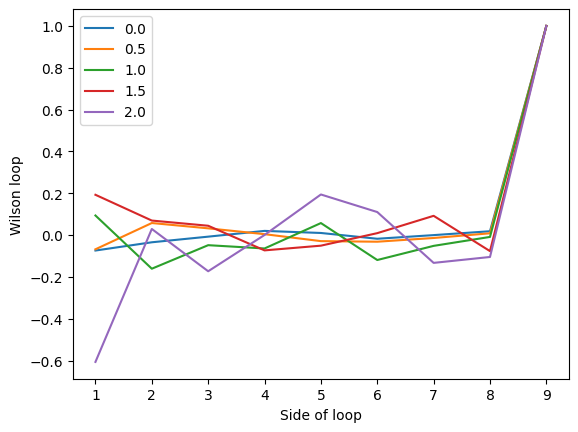

In [102]:
num_cores = multiprocessing.cpu_count()
betas = np.linspace(0, 2, 5)

with Parallel(n_jobs=num_cores) as parallel:
    ls = parallel(delayed(metropolis)(beta) for beta in tqdm(betas))

    arr = np.array(ls)
    side = np.arange(1,N)
    for i in range(len(betas)):
        plt.plot(side,arr[i,:],label=f'{betas[i]}')
    plt.xlabel('Side of loop')
    plt.ylabel('Wilson loop')
    plt.legend()
    plt.show()

In [109]:
# Initialize lattice with random U(1) elements
lattice = np.exp(1j * np.random.uniform(low = 0, high = 2*np.pi, size=(N,N,2)))

# Apply periodic boundary conditions
lattice[0, :, :] = lattice[N-1, :, :]
lattice[:,0, :] = lattice[:, N-1, :]     

wilson(lattice,9)

1.0000000000000002

In [135]:
def plaquette(i,j,lattice):
    return lattice[i,j,0] * lattice[(i+1)%N,j,1] * np.conj(lattice[i,(j+1)%N,0]) * np.conj(lattice[i,j,1])

#plaquette = np.vectorize(plaquette)

def wilson(lattice, a):
    i, j = np.indices((a, a))
    plaquettes = plaquette(i, j, lattice)
    p = np.prod(plaquettes)
    return np.real(p)

In [149]:
N = 10

# Define the action function
def calculate_action(lattice,beta):
 
    # Calculate the plaquette term in the action
    i_shifted = np.roll(lattice, shift=-1, axis=0)
    j_shifted = np.roll(lattice, shift=-1, axis=1)

    plaq = lattice[..., 0] * j_shifted[..., 1] * np.conj(i_shifted[..., 0]) * np.conj(lattice[..., 1])

    action_plaquette = np.real(1 - plaq).sum()

    # Calculate the total action
    return 2 * beta * action_plaquette

def X(eps):
    return np.exp(1j * np.random.uniform(low=0,high=2*np.pi))

def metropolis(beta,n_iterations=100000):
    
    # Initialize lattice with random U(1) elements
    lattice = np.exp(1j * np.random.uniform(low = 0, high = 2*np.pi, size=(N,N,2)))

    # Apply periodic boundary conditions
    lattice[0, :, :] = lattice[N-1, :, :]
    lattice[:,0, :] = lattice[:, N-1, :]            

    action_before = calculate_action(lattice,beta)
    ls = [[] for _ in range(N-1)]
        
    for iteration in range(n_iterations):
    
        # Choose a random lattice site and direction
        i = np.random.randint(N)
        j = np.random.randint(N)
        k = np.random.randint(2)

        # Generate a random U(1) element
        u1_elem = X(0.5)
        
        new_lattice = lattice.copy()

        # Update the gauge field at the chosen site
        new_lattice[i, j, k] = u1_elem * new_lattice[i, j, k]
        
        # Apply periodic boundary conditions
        new_lattice[0, :, :] = new_lattice[N-1, :, :]
        new_lattice[:,0, :] = new_lattice[:, N-1, :]

        # Calculate the action after the update
        action_after = calculate_action(new_lattice,beta)

        # Decide whether to accept or reject the update
        if np.random.random() < np.exp(action_before - action_after):
            # Accept the update
            lattice = new_lattice
            action_before = action_after
            
        if iteration >= 7*n_iterations/10:
            for i in range(N-1):
                ls[i].append(wilson(lattice,i+1))
    
    for i in range(N-1):
        ls[i] = np.array(ls[i]).mean()
    
    return ls

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16777.22it/s]


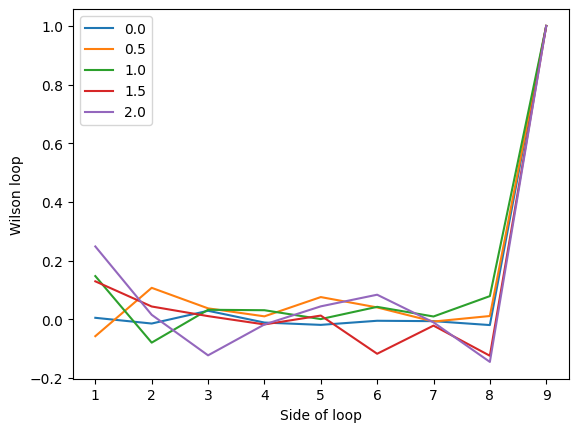

In [150]:
num_cores = multiprocessing.cpu_count()
betas = np.linspace(0, 2, 5)

with Parallel(n_jobs=num_cores) as parallel:
    ls = parallel(delayed(metropolis)(beta) for beta in tqdm(betas))

    arr = np.array(ls)
    side = np.arange(1,N)
    for i in range(len(betas)):
        plt.plot(side,arr[i,:],label=f'{betas[i]}')
    plt.xlabel('Side of loop')
    plt.ylabel('Wilson loop')
    plt.legend()
    plt.show()

In [140]:
# Initialize lattice with random U(1) elements
lattice = np.exp(1j * np.random.uniform(low = 0, high = 2*np.pi, size=(N,N,2)))

# Apply periodic boundary conditions
lattice[0, :, :] = lattice[N-1, :, :]
lattice[:,0, :] = lattice[:, N-1, :]  

wilson(lattice,2)

0.8145854897933578

In [152]:
ls[:][0]

[0.004736675162474547,
 -0.014788717540278275,
 0.028703742990737226,
 -0.01146569242283125,
 -0.019371264530822864,
 -0.0053555130292234935,
 -0.006658989546780257,
 -0.02000950535664836,
 1.0000000000001101]

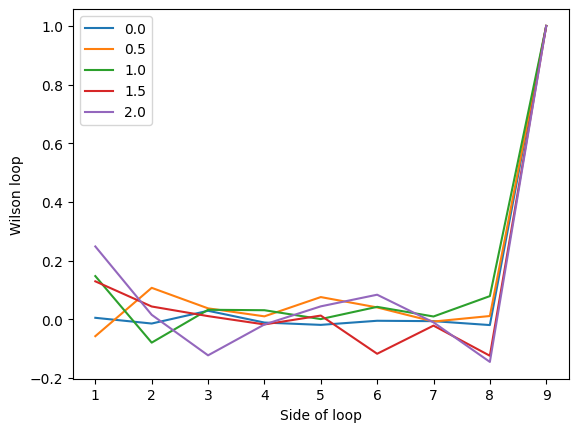

In [156]:
arr = np.array(ls)
side = np.arange(1,N)
for i in range(len(betas)):
    plt.plot(side,arr[i,:],label=f'{betas[i]}')
plt.xlabel('Side of loop')
plt.ylabel('Wilson loop')
plt.legend()
plt.show()